In [13]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

# Drive Mount & Install EfficientNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=2aa38946258a7556cf52042f50328f7f84c236f69a6a32a27006c92daa40736b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


# Zip Extract & corrupted file 제거
- 중복은 제거함

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Poster.zip') as zip_ref:
    zip_ref.extractall()

# with zipfile.ZipFile('/content/drive/MyDrive/Data/Poster/Book.zip') as zip_ref:
#     zip_ref.extractall()

In [ ]:
import PIL
from PIL import Image
import os
from tqdm.auto import tqdm

# 이미지가 저장된 디렉토리의 경로를 설정합니다.
image_directories = ['/content/Poster/Concert','/content/Poster/Contest','/content/Poster/Movie', '/content/Poster/Book']

# 손상된 파일의 목록을 저장할 리스트
corrupted_files = []

for image_directory in tqdm(image_directories):

    # 디렉토리 내의 모든 파일을 확인합니다.
    for filename in tqdm(os.listdir(image_directory)):
        # 파일 경로를 구성합니다.
        file_path = os.path.join(image_directory, filename)
        try:
            # 이미지 파일을 엽니다. 오류가 발생하면 except 블록으로 이동합니다.
            with Image.open(file_path) as img:
                # 파일이 이미지로 열리는지 간단하게 확인합니다.
                img.verify()
        except Exception as e:
            # 오류가 발생한 파일을 리스트에 추가합니다.
            corrupted_files.append(file_path)

    # 손상된 파일들을 제거하거나 다른 처리를 수행합니다.
for corrupted_file in corrupted_files:
    os.remove(corrupted_file)

print(f'Removed corrupted files')

In [ ]:
# save the corrupted_files
import pandas as pd
df = pd.DataFrame(corrupted_files)
df.columns = ['corrupted_files']
df.to_csv('/content/drive/MyDrive/final/corrupted_files.csv', index=False)

In [ ]:
import pandas as pd
import os

# CSV 파일에서 손상된 파일 목록 불러오기
corrupted_files_df = pd.read_csv('/content/drive/MyDrive/final/corrupted_files.csv')

# 파일 경로를 리스트로 변환
corrupted_files_list = corrupted_files_df['corrupted_files'].tolist()

# 손상된 파일들 삭제
for file_path in corrupted_files_list:
    # 파일이 존재하는지 확인 후 삭제
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f'Removed: {file_path}')
    else:
        print(f'File not found: {file_path}')

print('All corrupted files removed.')

All corrupted files removed.


# Calculate Mean&Std of our Dataset

## load Dataset

In [ ]:
# Custom dataset for MoCov2
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision.transforms as transforms
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_list = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.folder_path, self.image_list[idx])
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

norm_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset_Concert = CustomDataset(folder_path='/content/Poster/Concert', transform=norm_transform)
train_dataset_Contest = CustomDataset(folder_path='/content/Poster/Contest', transform=norm_transform)
train_dataset_Movie = CustomDataset(folder_path='/content/Poster/Movie', transform=norm_transform)
train_dataset_Book = CustomDataset(folder_path='/content/Poster/Book', transform=norm_transform)
train_dataset = ConcatDataset([train_dataset_Concert,train_dataset_Contest,train_dataset_Movie,train_dataset_Book])

## Calculate Mean&Std



In [ ]:
import numpy as np
from tqdm.auto import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

def calculate_norm_optimized(dataset):
    # RGB 채널을 위한 리스트 초기화
    channel_sums = np.zeros(3)
    channel_squares = np.zeros(3)
    num_pixels = 0

    # 데이터셋 순회
    for x in tqdm(dataset):
        x_np = x.numpy()
        # RGB 채널 별 평균을 계산하기 위해 합계 갱신
        channel_sums += np.sum(x_np, axis=(1, 2))
        # 제곱의 합계를 계산하여 표준편차 계산을 위해 사용
        channel_squares += np.sum(x_np**2, axis=(1, 2))
        # 총 픽셀 수 업데이트
        num_pixels += x_np.shape[1] * x_np.shape[2]

    # RGB 채널별 평균
    mean = channel_sums / num_pixels

    # RGB 채널별 표준편차
    std = np.sqrt(channel_squares / num_pixels - mean**2)

    return mean, std

mean_, std_ = calculate_norm_optimized(train_dataset)
print(f'평균(R,G,B): {mean_}\n표준편차(R,G,B): {std_}')

  0%|          | 0/275965 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


평균(R,G,B): [0.62706534 0.6120791  0.59086932]
표준편차(R,G,B): [0.37403608 0.35793398 0.36176297]


## save Mean&Std

In [ ]:
# 평균&표준편차 저장
import pickle

# 저장할 파일의 경로를 지정
file_path = '/content/drive/MyDrive/final/dataset_mean_std.pkl'

# mean_와 std_를 파일에 저장
with open(file_path, 'wb') as f:
    pickle.dump((mean_, std_), f)

print(f'평균 및 표준편차가 {file_path}에 저장됨')

평균 및 표준편차가 /content/drive/MyDrive/final/dataset_mean_std.pkl에 저장됨


## load Mean&Std

In [ ]:
file_path = '/content/drive/MyDrive/final/dataset_mean_std.pkl'

with open(file_path, 'rb') as f:
    mean_, std_ = pickle.load(f)

# Modeling

## Model Definition

In [ ]:
# EfficientNet-PyTorch (참조: "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks", Tan and Le, 2019)

# 아래는 MoCo v2에 대한 구현입니다. MoCo는 "Momentum Contrast for Unsupervised Visual Representation Learning" (He et al., 2020)에서 처음 소개되었습니다.
# MoCo v2는 "Improved Baselines with Momentum Contrastive Learning" (Chen et al., 2020)에서 소개되었습니다.
# 이 구현은 원 논문의 접근 방식을 기반으로 하며, 몇 가지 수정사항이 포함되어 있습니다.

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import models, datasets
import os
from tqdm.auto import tqdm
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import csv
import pandas as pd
import copy
import psutil

# epoch 및 hyperparameter 정의
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None
num_epochs = 50
learning_rate = 3e-4 # = initial learning rate for warm up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
projection_dim = 128
temperature = 0.07
momentum = 0.99
weight_decay = 1e-5
batch_size = 192
queue_size = 384
dropout_rate = 0.5

# Define the MoCov2 model
class MoCov2Model(nn.Module):
    def __init__(self, base_encoder, projection_dim=128, temperature=0.07, dropout_rate=0.5, queue_size=384, momentum=0.99):
        super(MoCov2Model, self).__init__()

        # 이미지 특징 추출 - 학습 & 추론 단계에서 모두 사용
        # EfficientNet + 128차원의 출력을 가진 선형 레이어 추가하여 DB에 저장할 특징 벡터의 차원 수 축소
        self.encoder = nn.Sequential(
            base_encoder,
            nn.Linear(1000, 128)
        )

        # Encoder에 의해 추출된 특징을 projection - 학습 과정에서 contrastive loss를 계산하는 데 사용, 추론 시엔 사용 X
        # Projection head 추가
        self.projection_head = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, projection_dim),
            nn.Dropout(dropout_rate)
        )

        # 모멘텀 인코더의 복사본 생성 (깊은 복사)
        self.momentum_encoder = copy.deepcopy(self.encoder)
        self.momentum_projection_head = copy.deepcopy(self.projection_head)

        # 모멘텀 인코더와 projection head의 모든 파라미터를 고정 (훈련 중 업데이트 방지)
        for param in self.momentum_encoder.parameters():
            param.requires_grad = False
        for param in self.momentum_projection_head.parameters():
            param.requires_grad = False

        # 기타 초기화
        self.queue = torch.zeros(queue_size, projection_dim).to(device)
        self.queue_ptr = 0
        self.momentum = momentum

    def _momentum_update(self):
        # 모멘텀 인코더 및 projection head의 가중치를 업데이트하는 함수
        with torch.no_grad():
            for param_q, param_k in zip(self.encoder.parameters(), self.momentum_encoder.parameters()):
                param_k.data = param_k.data * self.momentum + param_q.data * (1. - self.momentum)
            for param_q, param_k in zip(self.projection_head.parameters(), self.momentum_projection_head.parameters()):
                param_k.data = param_k.data * self.momentum + param_q.data * (1. - self.momentum)

    def forward(self, x, with_projection_head=True):
        x = self.encoder(x)
        if with_projection_head:
            x = self.projection_head(x)
        return x

    def enqueue_dequeue(self, keys):
        # 큐에 새로운 데이터 추가 및 오래된 데이터 제거 (CPU에서 수행)
        keys = keys.to('cpu')  # GPU에서 CPU로 이동
        batch_size = keys.size(0)
        ptr = int(self.queue_ptr)

        # replace the keys at ptr (dequeue and enqueue)
        space_left = self.queue.size(0) - ptr  # 남은 공간 계산
        # 마지막 배치의 크기가 다른 배치보다 작을 때 발생할 수 있는 예외 상황 처리
        if space_left < batch_size:
            # If 큐의 남은 공간이 batch_size보다 작을 경우, split the update
            self.queue[ptr:] = keys[:space_left]
            self.queue[:batch_size - space_left] = keys[space_left:]
            ptr = batch_size - space_left
        else:
            self.queue[ptr:ptr + batch_size] = keys
            ptr = (ptr + batch_size) % self.queue.size(0)  # move pointer

        self.queue_ptr = ptr

# 모델이 유사한 이미지를 서로 가깝게, 그리고 서로 다른 이미지를 멀게 배치하도록 학습
# MoCov2Loss(InfoNCE Loss)
class MoCov2Loss(nn.Module):
    def __init__(self, temperature=0.07):
        super(MoCov2Loss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j, queue):
        batch_size = z_i.size(0)

        # 특징 벡터 정규화
        z_i_norm = nn.functional.normalize(z_i, dim=1)
        z_j_norm = nn.functional.normalize(z_j, dim=1)
        queue_norm = nn.functional.normalize(queue, dim=1)

        # Positive 쌍에 대한 유사도 계산
        positive_sim = torch.exp(torch.sum(z_i_norm * z_j_norm, dim=1) / self.temperature)

        # Negative 쌍에 대한 유사도 계산
        negative_sim = torch.exp(torch.mm(z_i_norm, queue_norm.t()) / self.temperature)
        negative_sim_sum = torch.sum(negative_sim, dim=1)

        # 손실 계산
        loss = -torch.log(positive_sim / (positive_sim + negative_sim_sum)).mean()

        return loss

# Custom dataset for MoCov2
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_list = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.folder_path, self.image_list[idx])
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image_i = self.transform(image)
            image_j = self.transform(image)
        else:
            image_i = image
            image_j = image

        return image_i, image_j

# Early Stop to avoid overfitting
# Early stopping의 개념은 "Early Stopping - But When?" (Lutz Prechelt, 1998)에서 자세히 설명되어 있습니다.
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, epoch_loss, model):
        score = -epoch_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_loss, model)
            self.counter = 0

    def save_checkpoint(self, epoch_loss, model):
        '''Saves model when the validation loss decrease.'''
        if self.verbose:
            print(f'Training loss decreased ({self.best_score:.6f} --> {epoch_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)

# Set up the data loader for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.6, 1.)),
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),  # 밝기, 대비, 채도, 색조 조절
    transforms.RandomGrayscale(p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=9)], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_), # 수집한 데이터들의 RGB 픽셀 평균 & 표준편차 적용
])

# EfficientNet 모델을 로드하고 MoCov2 모델에 통합
# EfficientNet 관련 참조는 상단에 기술함
efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2').to(device)
mocov2_model = MoCov2Model(efficientnet_b2, projection_dim=projection_dim, temperature=temperature,
                           dropout_rate=dropout_rate, queue_size=queue_size, momentum=momentum).to(device)

# Set up the data loader for training
# train_dataset = CustomDataset(folder_path='/content/Poster/ConcertPoster', transform=train_transform)
train_dataset_Concert = CustomDataset(folder_path='/content/Poster/Concert', transform=train_transform)
train_dataset_Contest = CustomDataset(folder_path='/content/Poster/Contest', transform=train_transform)
train_dataset_Movie = CustomDataset(folder_path='/content/Poster/Movie', transform=train_transform)
train_dataset_Book = CustomDataset(folder_path='/content/Poster/Book', transform=train_transform)
train_dataset = ConcatDataset([train_dataset_Concert,train_dataset_Contest,train_dataset_Movie,train_dataset_Book])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Set up the optimizer
optimizer = optim.SGD(mocov2_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# Set up the MoCov2 loss function
criterion = MoCov2Loss(temperature = temperature)

Loaded pretrained weights for efficientnet-b2


## Train

In [ ]:
# 메모리 사용량 체크 함수, 90% 넘어가면 종료
def check_memory_usage(threshold):
    memory_usage = psutil.virtual_memory().percent
    return memory_usage > threshold

# 웜업 및 코사인 감소 스케줄링 함수 정의
def adjust_learning_rate(optimizer, epoch, initial_lr, num_epochs, warmup_epochs):
    """
        cosine decay schedule에 따라 에포크별 학습률 조정 (with warm-up)
    """
    if epoch < warmup_epochs:
        lr = initial_lr * (epoch + 1) / warmup_epochs
    else:
        lr = 0.5 * initial_lr * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

# 초기 학습률 및 웜업 에포크 설정
initial_lr = learning_rate  # 기존에 정의된 learning_rate 사용
warmup_epochs = 4  # 웜업 에포크 수

ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

os.makedirs('/content/drive/MyDrive/final', exist_ok=True)
early_stopping = EarlyStopping(patience=4, verbose=True, path='/content/drive/MyDrive/final/mocov2_best_model_231216.pth') # best model

train_losses = []

for epoch in range(num_epochs):
    mocov2_model.train()
    epoch_loss = 0.0

    # 학습률 조정
    current_lr = adjust_learning_rate(optimizer, epoch, initial_lr, num_epochs, warmup_epochs)

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images_i, images_j = batch
        images_i, images_j = images_i.to(device), images_j.to(device)

        # Forward pass
        features_q = mocov2_model(images_i)

        # 모멘텀 인코더 업데이트
        mocov2_model._momentum_update()

        with torch.no_grad():
            # 모멘텀 인코더를 사용하여 이미지를 인코딩하여 features_k를 계산
            features_k = mocov2_model.momentum_encoder(images_j)
            features_k = mocov2_model.momentum_projection_head(features_k)

            # CPU에 큐 업데이트
            mocov2_model.enqueue_dequeue(features_k)

            # 큐를 비동기적으로 GPU로 이동
            queue_gpu = mocov2_model.queue.to(device, non_blocking=True)

        # Loss 계산 (비동기적으로 이동된 queue 사용)
        loss = criterion(features_q, features_k, queue_gpu)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    # Print and save loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Learning Rate: {current_lr:.6f}')

    # Save the loss at each epoch to a CSV file
    with open('/content/drive/MyDrive/final/train_loss.csv', mode='a') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, epoch_loss])

    if (epoch + 1) % 10 == 0:
        plt.plot(train_losses, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.show()
        plt.close()

    early_stopping(epoch_loss, mocov2_model)

    if check_memory_usage(90):  # 예를 들어 사용 가능한 RAM의 90%를 초과하면
        print("High memory usage detected. Stopping training.")
        early_stopping(epoch_loss, mocov2_model)
        break

    if early_stopping.early_stop:
        print("Early stopping")
        plt.plot(train_losses, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.show()
        break

## save loss

In [ ]:
loss_data = {'epoch': [i+1 for i in range(len(train_losses))], 'loss': train_losses}

# 데이터프레임 생성
df = pd.DataFrame(loss_data)

target_path = '/content/drive/MyDrive/final'

# 폴더 생성
os.makedirs(target_path, exist_ok=True)

# CSV 파일로 저장
# csv_path = target_path + '/loss_data_MoCov2_EfficientNetB2_231215.csv'  # 저장할 경로 지정
csv_path = target_path + '/loss_data_MoCov2_EfficientNetB2_231215.csv'  # 저장할 경로 지정
df.to_csv(csv_path, index=False)

## save model

In [ ]:
torch.save(mocov2_model.state_dict(), '/content/drive/MyDrive/final/mocov2_best_model_231215.pth')

In [ ]:
from google.colab import files
# files.download('/content/drive/MyDrive/final/mocov2_best_model_231215.pth')
torch.save(optimizer.state_dict(), 'optimizer_state.pth')

os.makedirs(target_path, exist_ok=True)
_model = MoCov2Model(efficientnet_b2, projection_dim=projection_dim, temperature=temperature,
                           dropout_rate=dropout_rate, queue_size=queue_size, momentum=momentum).to(device)
_model.load_state_dict(torch.load('/content/drive/MyDrive/final/mocov2_best_model_231215.pth'))
torch.save(_model, target_path + '/mocov2_best_model_total_231215.pth')

## load model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import models, datasets
import os
from tqdm.auto import tqdm
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import csv
import pandas as pd
import copy
from google.colab import drive
import pickle

# epoch 및 hyperparameter 정의
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')

# Define the MoCov2 model
class MoCov2Model(nn.Module):
    def __init__(self, base_encoder, projection_dim=128, temperature=0.07, dropout_rate=0.5, queue_size=384, momentum=0.99):
        super(MoCov2Model, self).__init__()

        # 이미지 특징 추출 - 학습 & 추론 단계에서 모두 사용
        # EfficientNet + 128차원의 출력을 가진 선형 레이어 추가하여 DB에 저장할 특징 벡터의 차원 수 축소
        self.encoder = nn.Sequential(
            base_encoder,
            nn.Linear(1000, 128)
        )

        # Encoder에 의해 추출된 특징을 projection - 학습 과정에서 contrastive loss를 계산하는 데 사용, 추론 시엔 사용 X
        # Projection head 추가
        self.projection_head = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, projection_dim),
            nn.Dropout(dropout_rate)
        )

        # 모멘텀 인코더의 복사본 생성 (깊은 복사)
        self.momentum_encoder = copy.deepcopy(self.encoder)
        self.momentum_projection_head = copy.deepcopy(self.projection_head)

        # 모멘텀 인코더와 projection head의 모든 파라미터를 고정 (훈련 중 업데이트 방지)
        for param in self.momentum_encoder.parameters():
            param.requires_grad = False
        for param in self.momentum_projection_head.parameters():
            param.requires_grad = False

        # 기타 초기화
        self.queue = torch.zeros(queue_size, projection_dim).to(device)
        self.queue_ptr = 0
        self.momentum = momentum

    def _momentum_update(self):
        # 모멘텀 인코더 및 projection head의 가중치를 업데이트하는 함수
        with torch.no_grad():
            for param_q, param_k in zip(self.encoder.parameters(), self.momentum_encoder.parameters()):
                param_k.data = param_k.data * self.momentum + param_q.data * (1. - self.momentum)
            for param_q, param_k in zip(self.projection_head.parameters(), self.momentum_projection_head.parameters()):
                param_k.data = param_k.data * self.momentum + param_q.data * (1. - self.momentum)

    def forward(self, x, with_projection_head=True):
        x = self.encoder(x)
        if with_projection_head:
            x = self.projection_head(x)
        return x

    def enqueue_dequeue(self, keys):
        # 큐에 새로운 데이터 추가 및 오래된 데이터 제거 (CPU에서 수행)
        keys = keys.to('cpu')  # GPU에서 CPU로 이동
        batch_size = keys.size(0)
        ptr = int(self.queue_ptr)

        # replace the keys at ptr (dequeue and enqueue)
        space_left = self.queue.size(0) - ptr  # 남은 공간 계산
        # 마지막 배치의 크기가 다른 배치보다 작을 때 발생할 수 있는 예외 상황 처리
        if space_left < batch_size:
            # If 큐의 남은 공간이 batch_size보다 작을 경우, split the update
            self.queue[ptr:] = keys[:space_left]
            self.queue[:batch_size - space_left] = keys[space_left:]
            ptr = batch_size - space_left
        else:
            self.queue[ptr:ptr + batch_size] = keys
            ptr = (ptr + batch_size) % self.queue.size(0)  # move pointer

        self.queue_ptr = ptr

# load mean & std
file_path = '/content/drive/MyDrive/final/dataset_mean_std.pkl'

with open(file_path, 'rb') as f:
    mean_, std_ = pickle.load(f)

efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2').to(device)
mocov2_model = MoCov2Model(efficientnet_b2).to(device)

mocov2_model.load_state_dict(torch.load('/content/drive/MyDrive/final/mocov2_best_model_231216.pth'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 236MB/s]


Loaded pretrained weights for efficientnet-b2


<All keys matched successfully>

# similarity test

## save feature vector

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import os
import pickle

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_), # 학습 시 사용했던 평균 & 표준편차 값 사용
])

# 이미지 파일 경로 리스트를 가져오는 함수
def get_image_paths(folder_path):
    image_files = os.listdir(folder_path)
    image_paths = [os.path.join(folder_path, img) for img in image_files if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return image_paths

# 특징 벡터 dictionary를 pickle로 저장하는 함수
def save_feature_vectors(feature_vectors, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(feature_vectors, f)

# dataset의 특징 벡터를 저장하는 함수
def save_features(model, dataset_path, test_transform, feature_vectors_path):
    model = model.to(device)  # 모델을 GPU로 이동
    model.eval()
    feature_vectors = {}

    with torch.no_grad():
        for img_path in tqdm(get_image_paths(dataset_path)):
            dataset_image = test_transform(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
            dataset_feature_vector = model(dataset_image, with_projection_head=False).cpu().numpy()
            feature_vectors[img_path] = dataset_feature_vector

    save_feature_vectors(feature_vectors, feature_vectors_path)

# 이미지들이 있는 폴더 및 특징 벡터 저장 파일 경로
dataset_path = '/content/Poster/Movie'
# feature_vectors_path = '/content/drive/MyDrive/final/movie_feature_vectors_mocov2_model.pkl'
feature_vectors_path = '/content/movie_feature_vectors_mocov2_model.pkl'

# 특징 벡터 저장
save_features(mocov2_model, dataset_path, test_transform, feature_vectors_path)

  0%|          | 0/56787 [00:00<?, ?it/s]

## load feature vector

In [ ]:
# 특징 벡터를 load

def load_feature_vectors(file_path):
    with open(file_path, 'rb') as f:
        feature_vectors = pickle.load(f)
    return feature_vectors

feature_vectors_path = '/content/movie_feature_vectors_mocov2_model.pkl'
feature_vectors = load_feature_vectors(feature_vectors_path)

## calculate similarity 1 vs many

In [ ]:
# 이미지 유사도를 측정하는 함수
def measure_similarity(model, feature_vectors, test_image_path, test_transform):
    model = model.to(device)
    model.eval()
    similarities = []

    # 테스트 이미지 로드 및 전처리
    test_image = test_transform(Image.open(test_image_path).convert('RGB')).unsqueeze(0).to(device)

    # 모든 이미지에 대해 유사도 계산
    with torch.no_grad():
        test_feature_vector = model(test_image)

        for img_path, feature_vector in feature_vectors.items():
            feature_vector = torch.tensor(feature_vector).to(device)
            similarity_score = nn.functional.cosine_similarity(test_feature_vector, feature_vector)
            similarities.append((img_path, similarity_score.item()))

    return similarities

# 유사도를 측정할 이미지 path
test_image_path = '/caseC3.jpg'  # 유사도를 측정할 대상 이미지 경로

# 유사도 측정 실행
similarities = measure_similarity(mocov2_model, feature_vectors, test_image_path, test_transform)

# 상위 top_cnt개 유사도
top_cnt = 20

top_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_cnt]

## result plot

### without SSIM

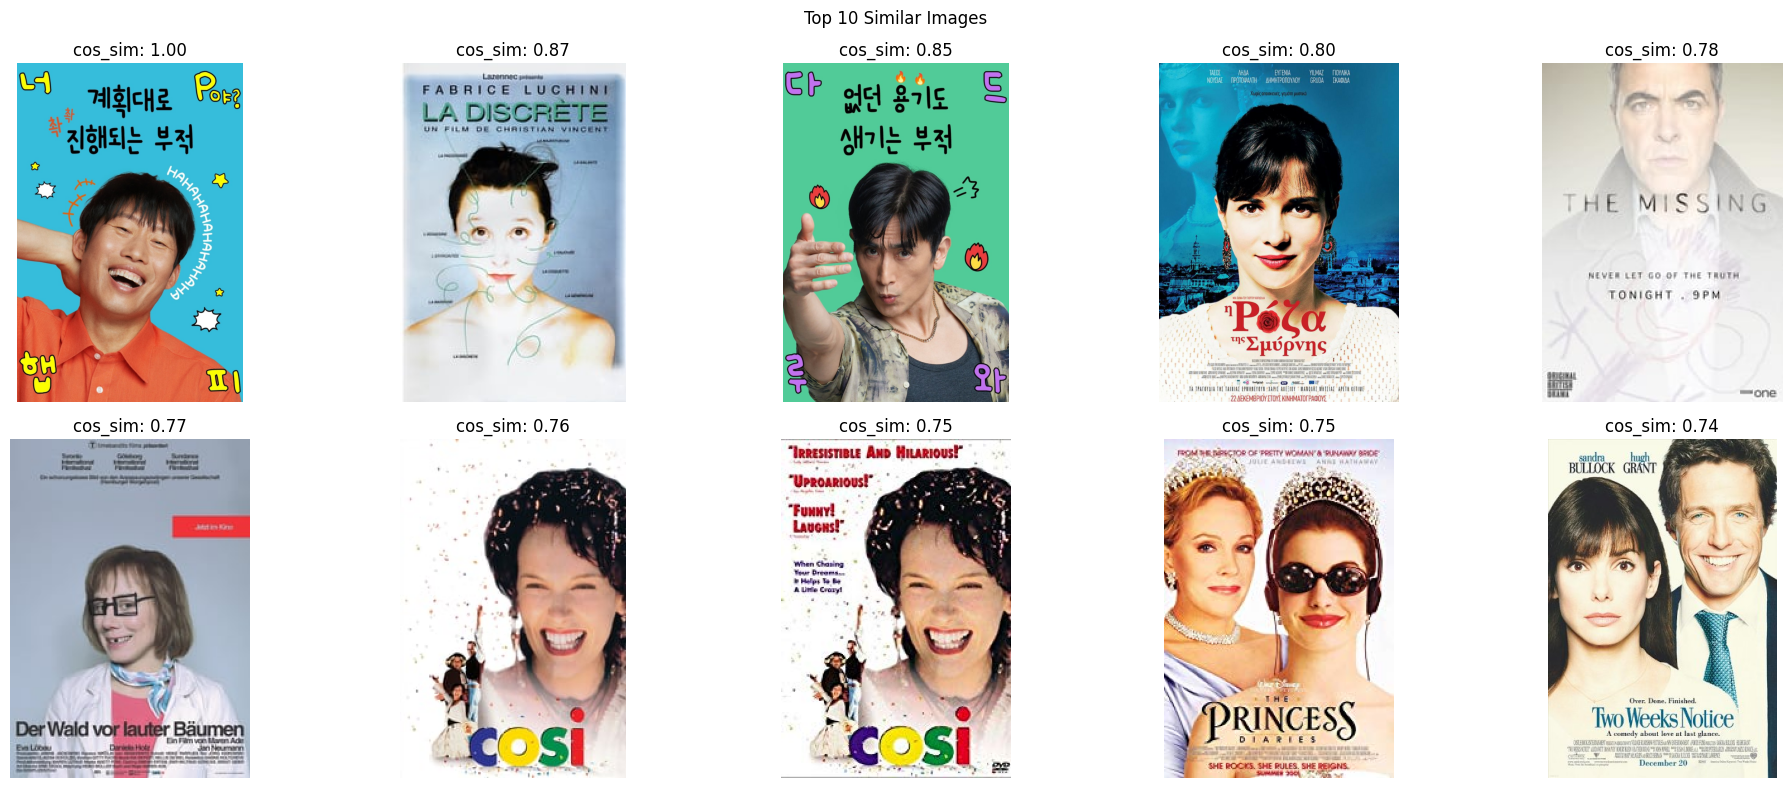

In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2

# 상위 top_cnt개 이미지 플롯
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle(f'Top 10 Similar Images')

for i, (img_path, sim_score) in enumerate(top_similarities[:10]):
    ax = axes[i // 5, i % 5]
    image = Image.open(img_path)
    ax.imshow(image)
    ax.set_title(f"cos_sim: {sim_score:.2f}")
    ax.axis('off')  # 축 표시를 끕니다.

plt.tight_layout()
plt.show()

### with SSIM

  0%|          | 0/20 [00:00<?, ?it/s]

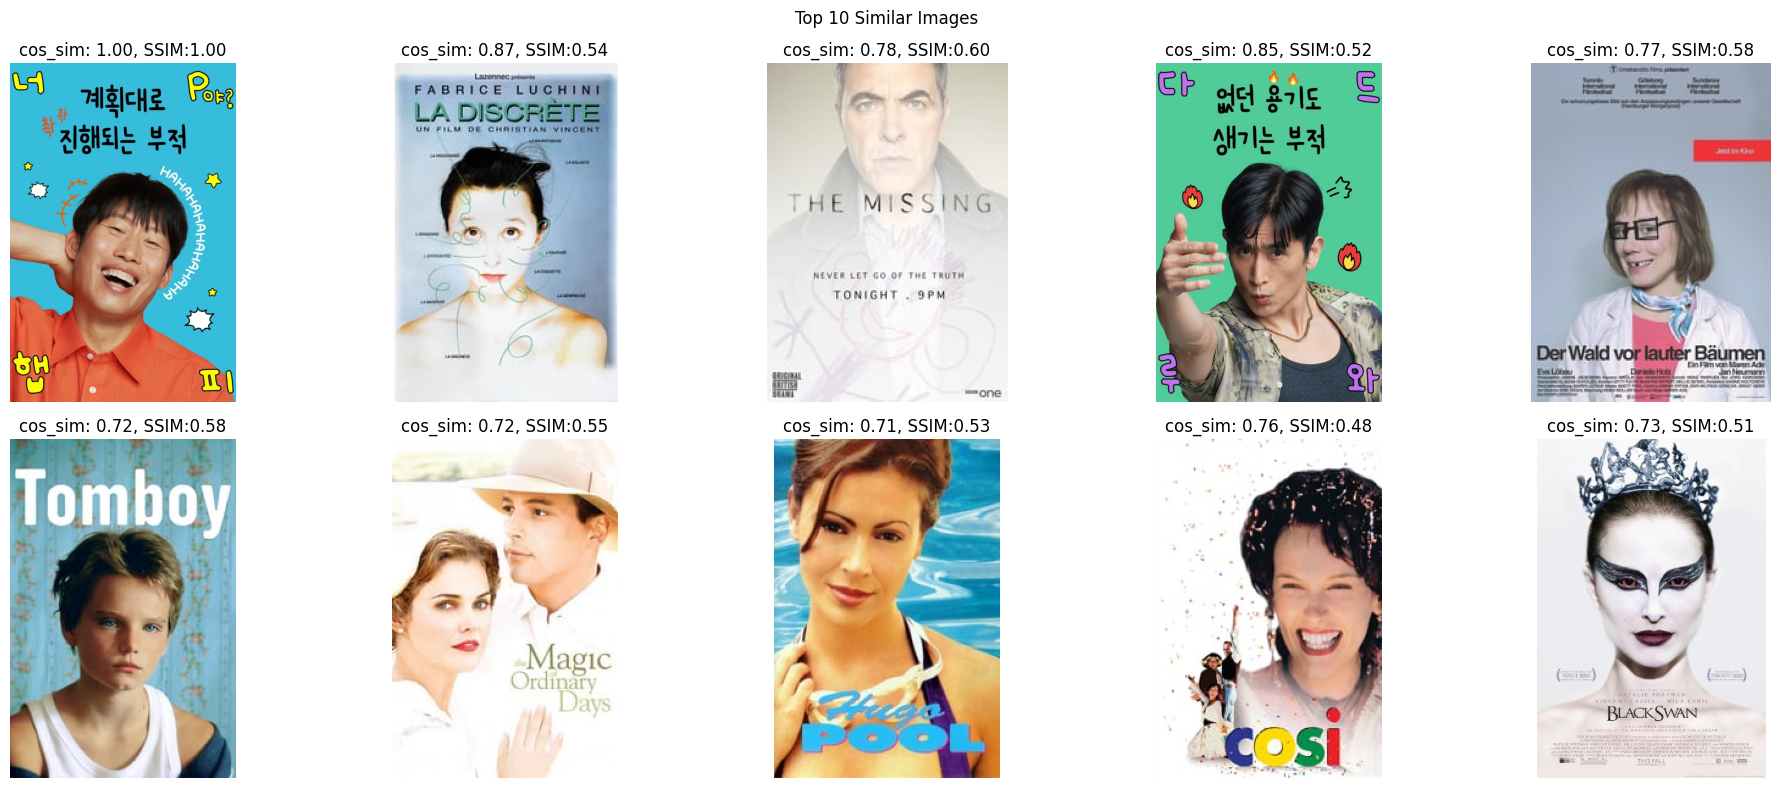

In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2

def sort_SSIM(top_similarities, test_image_path):
    new_top_similarities = []
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

    for dataset_img_path, cos_sim in tqdm(top_similarities):
        dataset_image = cv2.imread(dataset_img_path, cv2.IMREAD_GRAYSCALE)
        if dataset_image is None:
            continue
        # dataset_image의 크기를 test_image과 동일하게 조절
        dataset_image = cv2.resize(dataset_image, (test_image.shape[1], test_image.shape[0]))
        ssim_index = ssim(test_image, dataset_image)
        new_top_similarities.append((dataset_img_path, cos_sim, ssim_index))

    return sorted(new_top_similarities, key=lambda x: x[1] + x[2], reverse=True)

top10_similarities = sort_SSIM(top_similarities, test_image_path)[:10]

# 상위 top_cnt개 이미지 플롯
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle(f'Top 10 Similar Images')

for i, (img_path, sim_score, ssim_score) in enumerate(top10_similarities):
    ax = axes[i // 5, i % 5]
    image = Image.open(img_path)
    ax.imshow(image)
    ax.set_title(f"cos_sim: {sim_score:.2f}, SSIM:{ssim_score:.2f}")
    ax.axis('off')  # 축 표시를 끕니다.

plt.tight_layout()
plt.show()